# DS3000 - Group 13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

print("Path to dataset files:", path)

c:\Users\Jahangir Abdullayev\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 93.9k/93.9k [00:00<00:00, 2.07MB/s]

Extracting files...
Path to dataset files: C:\Users\Jahangir Abdullayev\.cache\kagglehub\datasets\lainguyn123\student-performance-factors\versions\7


In [3]:
df = pd.read_csv(path+"/StudentPerformanceFactors.csv")

In [4]:
df.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [17]:
# Dummy encode the non-numerical data
new_df = pd.get_dummies(df, columns=[
    'Parental_Involvement', 
    'Access_to_Resources', 
    'Extracurricular_Activities', 
    'Motivation_Level', 
    'Internet_Access',
    'Family_Income',
    'Teacher_Quality',
    'School_Type',
    'Peer_Influence',
    'Learning_Disabilities',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Gender',
], drop_first=False)

# Change name of Parental_Education_Level_High School to Parental_Education_Level_High_School cause it will confuse the calculation of linear, squared and interaction terms
new_df = new_df.rename(columns={"Parental_Education_Level_High School": "Parental_Education_Level_High_School"})

new_df.head(5)

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,Access_to_Resources_High,Access_to_Resources_Low,Access_to_Resources_Medium,Extracurricular_Activities_No,Extracurricular_Activities_Yes,Motivation_Level_High,Motivation_Level_Low,Motivation_Level_Medium,Internet_Access_No,Internet_Access_Yes,Family_Income_High,Family_Income_Low,Family_Income_Medium,Teacher_Quality_High,Teacher_Quality_Low,Teacher_Quality_Medium,School_Type_Private,School_Type_Public,Peer_Influence_Negative,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High_School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
0,23,84,7,73,0,3,67,False,True,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True
1,19,64,8,59,2,4,61,False,True,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,False,True,False,True,False,False,False,True,False,True,False
2,24,98,7,91,2,4,74,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,True,False,True
3,29,89,8,98,1,4,71,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True
4,19,92,6,65,3,4,70,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,True,False,True,False,False,False,False,True,True,False


In [6]:
# Setting our target variable to be 'Exam_Score'
X = new_df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

# Split the dataset into training and test sets (50% holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [7]:
def get_example_interaction(feature_names):
    interaction_terms = [name for name in feature_names if " " in name and "^" not in name]
    return interaction_terms[0] if interaction_terms else "No interaction terms found"

# Defining polynomial values so that PolynomialFeatures gives quadratic terms and exlcudes bias for all instances
poly = PolynomialFeatures(degree=2, include_bias=False)

# Create the first training set with quadratic terms of all features
X_train_poly = poly.fit_transform(X_train)
feature_names_all = poly.get_feature_names_out(X_train.columns)

# Count features
print("Total terms before poly: ", X_train.shape[1])
print("Total terms after poly: ", X_train_poly.shape[1])

linear_terms = sum(1 for f in feature_names_all if ' ' not in f and '^2' not in f)
squared_terms = sum(1 for f in feature_names_all if '^2' in f)
interaction_terms = sum(1 for f in feature_names_all if ' ' in f and '^2' not in f)
print(f"Linear terms: {linear_terms}")
print(f"Squared terms: {squared_terms}")
print(f"Interaction terms: {interaction_terms}")

Total terms before poly:  40
Total terms after poly:  860
Linear terms: 40
Squared terms: 40
Interaction terms: 780


In [8]:
 # Defining a function to process each training set, function takes in the pipeline, training set x, and training set y
def evaluate_model(X, y, pipeline):
    # Perform 10-fold cross-validation with mean squared error as the scoring metric
    mse_scores = -cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')

    # Return mean and std deviation of MSE
    return mse_scores.mean(), mse_scores.std()

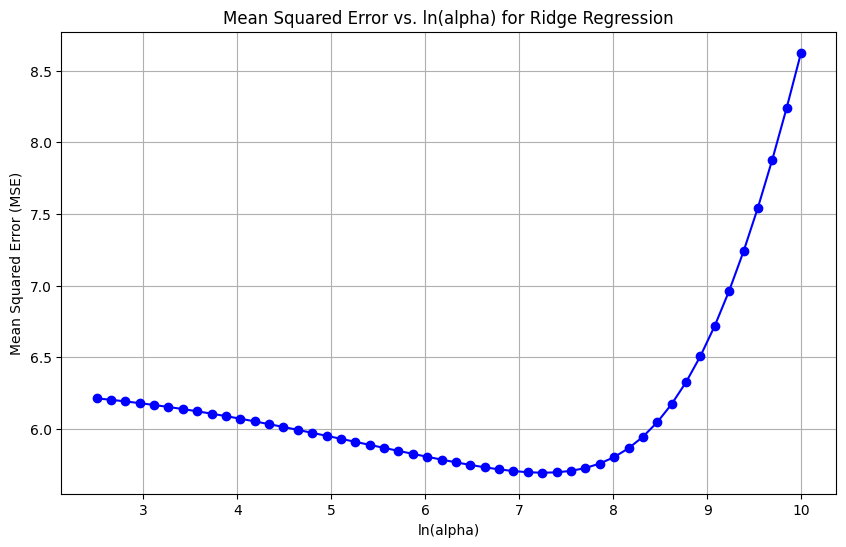

In [9]:
# Creating 15 alpha values ranging from exp(-8) to exp(6) and saving it to alphas
alphas = np.logspace(2.5, 10, num=50, base=np.e)

# Creating an array to store the computed mean squared errors
mse_scores = []

# Running the pipeline on each alpha and recording only the mean MSE value for each
for alpha in alphas:
    # Define the pipeline with the current alpha
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
    
    # Calculate cross-validated mean squared error with the function defined in previous cell
    mean_mse, _ = evaluate_model(X_train_poly, y_train, pipeline)
    mse_scores.append(mean_mse)

# Plotting MSE as a function of the log(alpha)
plt.figure(figsize=(10, 6))
plt.plot(np.log(alphas), mse_scores, marker='o', linestyle='-', color='b')
plt.xlabel("ln(alpha)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Mean Squared Error vs. ln(alpha) for Ridge Regression")
plt.grid(True)
plt.show()

In [10]:
# Get lowest MSE index and cross ref w correlated alpha
best_mse_index = np.argmin(mse_scores)
best_alpha = alphas[best_mse_index]
best_mse = mse_scores[best_mse_index]
print("The best mse is " + str(best_mse) + " at the alpha " + str(best_alpha))

The best mse is 5.693754611811304 at the alpha 1400.938935728998


In [11]:
# Make ridge model pipeline with best alpha from last cell
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),          # Step 1: Standardize the features
    ('ridge', Ridge(alpha=best_alpha))     # Step 2: Apply Ridge regression
])

# Fit the Ridge regression model with the scaled training data
ridge_pipeline.fit(X_train_poly, y_train)

# Will predict on the test data
X_test_poly = poly.fit_transform(X_test)
y_pred = ridge_pipeline.predict(X_test_poly)



# Calculate the Mean Squared Error on the test data
mse_test = mean_squared_error(y_test, y_pred)

# Manually Calculate R² (Proportion of Variance Explained)
y_true_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_true_mean) ** 2)  # Total sum of squares (variation in the data)
ss_residual = np.sum((y_test - y_pred) ** 2)   # Residual sum of squares (error between actual and predicted)
r2_test = 1 - (ss_residual / ss_total)

# Will use bootstrap sampling to find the mean MSE and 95% CI
# Set the number of bootstrap iterations and the size of the test set
# In theory, if n goes to infinity, we would get a true 95% CI
n_iterations = 500
test_size = 0.2
n_samples = len(X_train_poly)
n_test = int(n_samples * test_size)  # Size of the test set

mse_scores = []
r2_scores = []

# Perform bootstrap sampling
for _ in range(n_iterations):
    # Generate a bootstrap sample (with replacement) for the training data
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_resampled = X_train_poly[indices]
    y_resampled = y_train.iloc[indices]
    
    # Fit the model to the resampled data
    ridge_pipeline.fit(X_resampled, y_resampled)
    
    # Predict on the original test set
    y_pred_sample = ridge_pipeline.predict(X_test_poly)
    
    # Calculate the MSE for the current iteration
    mse = mean_squared_error(y_test, y_pred_sample)
    mse_scores.append(mse)

    # Manually Calculate R^2 for the current iteration
    ss_residual_sample = np.sum((y_test - y_pred_sample) ** 2)  # Residual sum of squares (error)
    r2 = 1 - (ss_residual_sample / ss_total)  # R² calculation
    r2_scores.append(r2)

# Calculate the 95% confidences interval using percentiles
mse_array = np.array(mse_scores)
r2_array = np.array(r2_scores)

lower_bound = np.percentile(mse_array, 2.5)
upper_bound = np.percentile(mse_array, 97.5)

r2_lower_bound = np.percentile(r2_array, 2.5)
r2_upper_bound = np.percentile(r2_array, 97.5)

# Report the results
print(f"Test data MSE: {mse_test:.4f}")
print(f"95% Confidence Interval for MSE: ({lower_bound:.6f}, {upper_bound:.6f})")

print(f"Test data R²: {r2_test:.4f}")
print(f"95% Confidence Interval for R²: ({r2_lower_bound:.4f}, {r2_upper_bound:.4f})")

Test data MSE: 3.2730
95% Confidence Interval for MSE: (3.283111, 3.774851)
Test data R²: 0.7621
95% Confidence Interval for R²: (0.7257, 0.7614)


In [16]:
# Make ridge model pipeline with best alpha from last cell
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),          # Step 1: Standardize the features
    ('ridge', Ridge(alpha=best_alpha))     # Step 2: Apply Ridge regression
])

# Fit the Ridge regression model with the scaled training data
ridge_pipeline.fit(X_train_poly, y_train)

# Retrieve the feature names after transformation (specific to polynomial features)
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

# Get the coefficients from the Ridge model
ridge_coefficients = ridge_pipeline.named_steps["ridge"].coef_

# Create a dictionary mapping each feature name to its corresponding coefficient
feature_coef_dict = dict(zip(feature_names, ridge_coefficients))

# Print each feature and its coefficient
# for feature, coef in feature_coef_dict.items():
#     print(f"Feature: {feature}, Coefficient: {coef}")

print("")
print("")
print("IMPORTANT")

# Sort features by absolute coefficient values in descending order
sorted_features = sorted(feature_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Filter out zero coefficients if necessary and select the top unique coefficients
top_features = []
for feature, coef in sorted_features:
    if coef != 0:  # Remove this line if zero coefficients should be considered
        top_features.append((feature, coef))
    if len(top_features) == 5:
        break

top_features_linear = []
for feature, coef in sorted_features:
    if ' ' not in feature and '^2' not in feature:
        top_features_linear.append((feature, coef))
    if len(top_features_linear) == 5:
        break

# Print the top 3 features and their coefficients
print("Top features with the largest coefficients:")
for feature, coef in top_features:
    print(f"Feature: {feature}, Coefficient: {coef}")


print()

# Find the feature with the smallest absolute coefficient
smallest_feature = min(feature_coef_dict, key=lambda k: feature_coef_dict[k])
smallest_coefficient = feature_coef_dict[smallest_feature]

# Print the feature with the smallest coefficient
print(f"Feature with the smallest coefficient: {smallest_feature}, Coefficient: {smallest_coefficient}")

print()

# Calculate the average of the coefficients
average_coefficient = sum(feature_coef_dict.values()) / len(feature_coef_dict)

# Print the average coefficient
print(f"Average coefficient: {average_coefficient}")

print("\n")

print("Top linear features with the largest coefficients:")
for feature, coef in top_features_linear:
    print(f"Feature: {feature}, Coefficient: {coef}")




IMPORTANT
Top features with the largest coefficients:
Feature: Attendance, Coefficient: 0.530070041149332
Feature: Attendance^2, Coefficient: 0.5197555758663477
Feature: Hours_Studied Attendance, Coefficient: 0.40608844817912304
Feature: Attendance Previous_Scores, Coefficient: 0.38640474188730684
Feature: Attendance Sleep_Hours, Coefficient: 0.2291198429974676

Feature with the smallest coefficient: Sleep_Hours, Coefficient: -0.07040240380809593

Average coefficient: 0.008809455992437739


Top linear features with the largest coefficients:
Feature: Attendance, Coefficient: 0.530070041149332
Feature: Hours_Studied, Coefficient: 0.20207690171384038
Feature: Previous_Scores, Coefficient: 0.07356936447380523
Feature: Sleep_Hours, Coefficient: -0.07040240380809593
Feature: Tutoring_Sessions, Coefficient: 0.03776345432506639
